## Bayesian Euros Forecast

# TODO
- [1] Formulate naive assumptions of independent Poisson
- [2] Set Bayesian stage, by assuming the parameters to be random variables (give intuition about how one could inject subjective information about team strength)
- [3] Explain Graphical Models pipeline: Define/Learn/Inference
- [4] Conduct model definition and learning
- [5] Prediction:
    - How to integrate over the predicitve in PyMC3?

### Assumptions
- goals of each team are independently distributied (Poisson)
- intensity parameter $\lambda$ is modelled as a linear combination of some latent factors $att$, $def$ (TODO: remove home advantage parameter)
- we don't consider the setup of the tournament (different stages, etc.), just try to infer latent team strength paramters

## Import data 

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
import matplotlib.pyplot as plt

%matplotlib inline

In [49]:
columns = ['home_score', 'away_score', 'home_team', 'away_team']

fixtures = [[2,1,'France','Romania'],
			[0,1,'Albania','Switzerland'],
			[1,1,'England','Russia'],
			[2,1,'Wales','Slovakia'],
			[0,1,'Turkey','Croatia'],
			[2,0,'Germany','Ukraine'],
			[1,0,'Poland','Northern Ireland'],
			[1,0,'Spain','Czech Republic'],
			[0,2,'Belgium','Italy'],
			[1,1,'Ireland','Sweden'],
			[0,2,'Austria','Hungary'],
			[1,1,'Portugal','Iceland'],

			[1,2,'Russia','Slovakia'],
			[2,0,'France','Albania'],
			[1,1,'Romania','Switzerland'],
			[2,1,'England','Wales'],
			[0,0,'Germany','Poland'],
			[0,2,'Ukraine','Northern Ireland'],
			[1,0,'Italy','Sweden'],
			[3,0,'Spain','Turkey'],
			[2,2,'Czech Republic','Croatia'],
			[3,0,'Belgium','Ireland'],
			[0,0,'Portugal','Austria'],
			[1,1,'Iceland','Hungary'],

			[0,0,'Switzerland','France'],
			[0,1,'Romania','Albania'],
			[0,3,'Russia','Wales'],
			[0,0,'Slovakia','England'],
			[0,1,'Ukraine','Poland'],
			[0,2,'Czech Republic', 'Turkey'],
			[0,1,'Northern Ireland', 'Germany'],
			[2,1,'Croatia','Spain'],
			[2,1,'Iceland','Austria'],
			[0,1,'Italy','Ireland'],
			[3,3,'Hungary','Portugal'],
			[0,1,'Sweden','Belgium']]

fxts = pd.DataFrame(data=fixtures, columns=columns)

- create team index to identify goals during modelling

In [93]:
teams = fxts.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

fxts = pd.merge(fxts, teams, left_on='home_team', right_on='team', how='left')
fxts = fxts.rename(columns = {'i': 'i_home'}).drop('team', 1)
fxts = pd.merge(fxts, teams, left_on='away_team', right_on='team', how='left')
fxts = fxts.rename(columns = {'i': 'i_away'}).drop('team', 1)

fxts.iloc[0:5,]

,home_score,away_score,home_team,away_team,i_home,i_away,i_home,i_away
0,2,1,France,Romania,0,13,0,13
1,0,1,Albania,Switzerland,1,18,1,18
2,1,1,England,Russia,2,12,2,12
3,2,1,Wales,Slovakia,3,19,3,19
4,0,1,Turkey,Croatia,4,21,4,21


- Goals are assumed to follow a Poisson distribution
- let's plot the goals and try to verify this by fitting a Poisson to the observed goals (for simplicity we combine home and away goals)

set([0, 1, 2, 3, 4, 6])


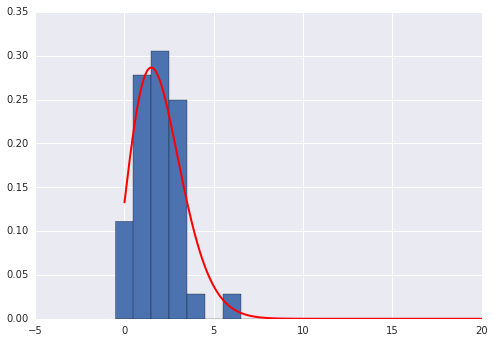

In [77]:
from scipy.optimize import curve_fit
from scipy.misc import factorial
from theano import shared

observed_home_goals = fxts.home_score.values
observed_away_goals = fxts.away_score.values

# Turn observations into shared variable to make predictions later
shared_home_goals = shared(observed_home_goals)
shared_away_goals = shared(observed_away_goals)

overall_goals = observed_away_goals + observed_home_goals

print(set(overall_goals))

# get poisson deviated random numbers
data = overall_goals

# the bins should be of integer width, because poisson is an integer distribution
entries, bin_edges, patches = plt.hist(data, bins=11, range=[-0.5, 10.5], normed=True)

# calculate binmiddles
bin_middles = 0.5*(bin_edges[1:] + bin_edges[:-1])

# poisson function, parameter lamb is the fit parameter
def poisson(k, lamb):
    return (lamb**k/factorial(k)) * np.exp(-lamb)

# fit with curve_fit
parameters, cov_matrix = curve_fit(poisson, bin_middles, entries) 

# plot poisson-deviation with fitted parameter
x_plot = np.linspace(0, 20, 1000)

plt.plot(x_plot, poisson(x_plot, *parameters), 'r-', lw=2)
plt.show()

- Let's build the model
- [small excursion about probailistic programmgin]

In [53]:
home_team = fxts.i_home.values
away_team = fxts.i_away.values

num_teams = len(fxts.i_home.drop_duplicates())
num_games = len(home_team)

In [54]:
print "num_teams:%d, num_games:%d" %(num_teams,num_games)

num_teams:24, num_games:36


In [78]:
with pm.Model() as model:    
    # global model parameters
    home        = pm.Normal('home',      0, .0001)
    tau_att     = pm.Gamma('tau_att',   .1, .1)
    tau_def     = pm.Gamma('tau_def',   .1, .1)
    intercept   = pm.Normal('intercept', 0, .0001)

    # team-specific model parameters
    # TODO: why is mu not a random variable? Is it becasue we center data to
    # reduce uncertainty about the mean?
    atts_star   = pm.Normal("atts_star",
                           mu = 0,
                           tau = tau_att,
                           shape = num_teams)
    defs_star   = pm.Normal("defs_star",
                           mu = 0,
                           tau = tau_def,
                           shape = num_teams)

    atts        = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs        = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta  = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta  = tt.exp(intercept + atts[away_team] + defs[home_team])

    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=shared_home_goals)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=shared_away_goals)

Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.


- fit the model via MCMC (simulation) and analyse posterior (sanity check)

In [79]:
# Fit data, starting with the MAP
with model:    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start)

 [-----------------100%-----------------] 2000 of 2000 complete in 35.6 sec

array([[<matplotlib.axes.AxesSubplot object at 0x12a052c50>,
        <matplotlib.axes.AxesSubplot object at 0x12a1ecfd0>]], dtype=object)

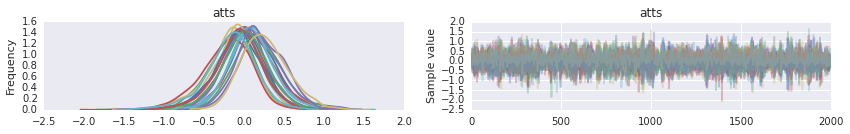

In [80]:
# Plot posteriors
pm.traceplot(trace, [atts])

- the juicy bits: plot latent paramters: do they make sense? kinda, well our assumptions where a bit bold!

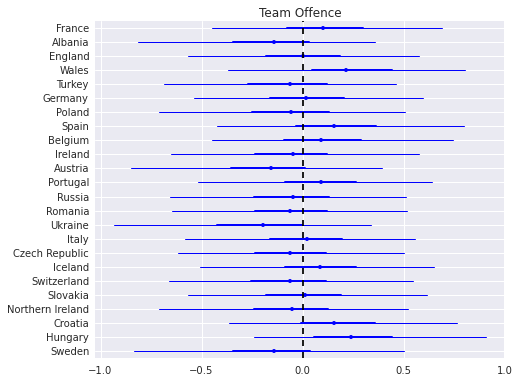

In [81]:
# Plot attack parameters
pm.forestplot(trace, varnames=['atts'], ylabels=teams['team'].values, main="Team Offence")

- Now the interesting part: remember we defined the observations as a "tensor" shared variable -> hence allowing us to change the data after training and make predictions
- TODO: how to constrain predictions to two teams only? -> predict the final based on the latent factors we learend from the group phase! -> summarize predicted goals by the mode and identify winner!

In [86]:
# Changes values of the model
shared_home_goals.set_value([0]*36)
shared_away_goals.set_value([0]*36)

In [87]:
ppc = pm.sample_ppc(trace, samples=1, model=model, size=1)

In [96]:
## Can I predict from that?
ppc

{'away_points': array([[2, 1, 0, 1, 2, 0, 0, 0, 1, 0, 0, 0, 5, 3, 1, 1, 0, 0, 1, 2, 1, 2,
         1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 0, 1, 0]]),
 'home_points': array([[0, 3, 0, 1, 1, 5, 1, 0, 1, 1, 0, 2, 3, 0, 1, 2, 1, 0, 1, 0, 1, 0,
         0, 0, 0, 2, 0, 0, 0, 2, 0, 3, 1, 1, 2, 0]])}

In [107]:
ppc['home_points'].mean(axis=0)

array([ 0.,  3.,  0.,  1.,  1.,  5.,  1.,  0.,  1.,  1.,  0.,  2.,  3.,
        0.,  1.,  2.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,
        0.,  0.,  0.,  2.,  0.,  3.,  1.,  1.,  2.,  0.])

In [134]:
i = trace['intercept'].mean(axis=0)
h = trace['home'].mean(axis=0)
atts = trace['atts'].mean(axis=0)
defs = trace['defs'].mean(axis=0)

# Predict team 0 against team 1
theta_0 = np.exp(atts[0] + defs[1] + i + h)
theta_1 = np.exp(atts[1] + defs[0] + i + h)

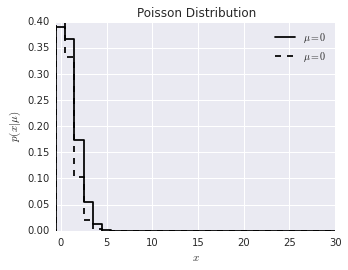

In [136]:
from scipy.stats import poisson

mu_values = [theta_0, theta_1]
linestyles = ['-', '--']

fig, ax = plt.subplots(figsize=(5, 3.75))

for mu, ls in zip(mu_values, linestyles):
    dist = poisson(mu)
    x = np.arange(-1, 200)

    plt.plot(x, dist.pmf(x), ls=ls, color='black',
             label=r'$\mu=%i$' % mu, linestyle='steps-mid')

plt.xlim(-0.5, 30)
plt.ylim(0, 0.4)

plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu)$')
plt.title('Poisson Distribution')

plt.legend()
plt.show()